In [1]:
import pandas as pd
from prophet import Prophet
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [2]:
df = pd.read_csv("dataset_cuaca_perjam-prophet.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_12332\3586419131.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset_cuaca_perjam-prophet.csv")


In [3]:
df

,date,year,month,day,hour,t2m,rh2m,ps,ws10m
0,11/30/2013,2013.0,11.0,30.0,7:00:00,27.36,78.94,100.80,3.17
1,11/30/2013,2013.0,11.0,30.0,8:00:00,28.47,73.19,100.85,2.65
2,11/30/2013,2013.0,11.0,30.0,9:00:00,29.44,69.56,100.83,2.04
3,11/30/2013,2013.0,11.0,30.0,10:00:00,30.12,67.38,100.77,1.73
4,11/30/2013,2013.0,11.0,30.0,11:00:00,30.44,66.38,100.70,1.87
...,...,...,...,...,...,...,...,...,...
1048570,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048571,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048572,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048573,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PREPROCESSING

In [4]:
df.dropna(inplace=True)

In [5]:
df = df.drop(columns=['year', 'month', 'day'], axis=1)

In [6]:
df.isnull().sum()

date     0
hour     0
t2m      0
rh2m     0
ps       0
ws10m    0
dtype: int64

In [7]:
df.dtypes

date      object
hour      object
t2m      float64
rh2m     float64
ps       float64
ws10m    float64
dtype: object

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_timedelta(df['hour'])
df['time'] = df['date'] + df['hour']

In [9]:
del df['date']
del df['hour']

In [10]:
df.rename(
    columns={"time": "ds", "ws10m": "y"},
    inplace=True,
)

In [11]:
df.dtypes

t2m            float64
rh2m           float64
ps             float64
y              float64
ds      datetime64[ns]
dtype: object

In [12]:
df.set_index(df['ds'], inplace = True)

In [13]:
# df['T_target'] = df.shift(-1)['T2M']
# df['RH_target'] = df.shift(-1)['RH2M']
# df['PS_target'] = df.shift(-1)['PS']
# df['WS_target'] = df.shift(-1)['WS10M']

In [14]:
df.dropna(inplace=True)

In [15]:
import numpy as np 

Q1 = np.percentile(df['y'], 25)
Q3 = np.percentile(df['y'], 75)

IQR = Q3 - Q1

lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

outliers = (df['y'] < lower_fence) | (df['y'] > upper_fence)
num_outliers = sum(outliers)

print("Jumlah outlier:", num_outliers)



Jumlah outlier: 1188


In [16]:
# import seaborn as sns
# def replace_interpolate(df, column):
#     sns.boxplot(df[column])
#     plt.title(f'Original Box Plot of {column}')
#     plt.show()

#     # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)

#     # Calculate the Interquartile Range (IQR)
#     IQR = Q3 - Q1

#     # Define the lower and upper fences
#     lower_fence = Q1 - 1.5 * IQR
#     upper_fence = Q3 + 1.5 * IQR

#     # Identify outliers
#     outliers = (df[column] < lower_fence) | (df[column] > upper_fence)

#     # Replace outliers with NaN
#     df[column][outliers] = np.nan

#     # Interpolate the NaN values
#     df[column] = df[column].interpolate()

#     sns.boxplot(df[column])
#     plt.title(f'Box Plot after Replacing Outliers of {column}')
#     plt.show()

#     return df

# # Sample usage
# # Assuming 'df' is your DataFrame and 'T2M' is the column name you want to process
# df = replace_interpolate(df, 'y')

In [17]:
# # df.sort_index(inplace=True)

# # start_date = '2021-04-01 09:00:00'
# # end_date = '2022-05-01 16:00:00'

# df = df.iloc[-100:]

In [18]:
# del df['ds']
# del df['rh2m']
# del df['ps']
# del df['ws10m']

In [19]:
# # Concatenate all variables into one DataFrame
# df = pd.DataFrame()
# df_prophet['ds'] = df['ds']
# df_prophet['y'] = df['y']
# df_prophet['humidity'] = df['rh2m']
# df_prophet['wind_speed'] = df['ws10m']
# df_prophet['pressure'] = df['ps']

In [20]:
df = df.sort_index()

train_percentage = 0.8
train_size = int(len(df) * train_percentage)

train_data = df[:train_size]
test_data = df[train_size:]

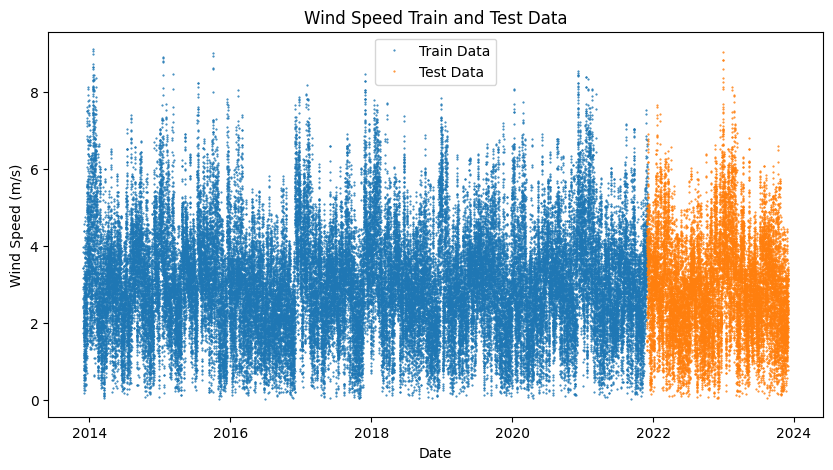

In [21]:
color_pal=sns.color_palette()
plt.figure(figsize=(10, 5))
plt.plot(train_data['y'].index, train_data['y'].values, '.', ms=1, color=color_pal[0], label='Train Data')
plt.plot(test_data['y'].index, test_data['y'].values, '.', ms=1, color=color_pal[1], label='Test Data')
plt.title('Wind Speed Train and Test Data')
plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

# traingin

In [22]:

params = {
    'growth': 'linear',
    'changepoints': None,
    'n_changepoints': 25,
    'changepoint_range': 0.8,
    'yearly_seasonality': 'auto',
    'weekly_seasonality': 'auto',
    'daily_seasonality': 'auto',
    'seasonality_mode': 'additive',
    'seasonality_prior_scale': 10.0,
    'holidays_prior_scale': 10.0,
    'changepoint_prior_scale': 0.05,
    'mcmc_samples': 0,
    'interval_width': 0.80,
    'uncertainty_samples': 1000,
    'stan_backend': None
}




model = Prophet(**params)
model.add_regressor('rh2m')
model.add_regressor('t2m')
model.add_regressor('ps')
df['t2m'] = df['t2m']+1

In [23]:
df

,t2m,rh2m,ps,y,ds
ds,,,,,
2013-11-30 07:00:00,28.36,78.94,100.80,3.17,2013-11-30 07:00:00
2013-11-30 08:00:00,29.47,73.19,100.85,2.65,2013-11-30 08:00:00
2013-11-30 09:00:00,30.44,69.56,100.83,2.04,2013-11-30 09:00:00
2013-11-30 10:00:00,31.12,67.38,100.77,1.73,2013-11-30 10:00:00
2013-11-30 11:00:00,31.44,66.38,100.70,1.87,2013-11-30 11:00:00
...,...,...,...,...,...
2023-12-01 02:00:00,28.05,87.56,100.63,1.50,2023-12-01 02:00:00
2023-12-01 03:00:00,27.88,89.00,100.62,1.87,2023-12-01 03:00:00
2023-12-01 04:00:00,27.82,89.19,100.67,1.86,2023-12-01 04:00:00


In [24]:
fit_model = model.fit(train_data)

01:07:29 - cmdstanpy - INFO - Chain [1] start processing
01:08:56 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
forecast = fit_model.predict(test_data)

In [26]:
f_train = fit_model.predict(train_data)

c:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


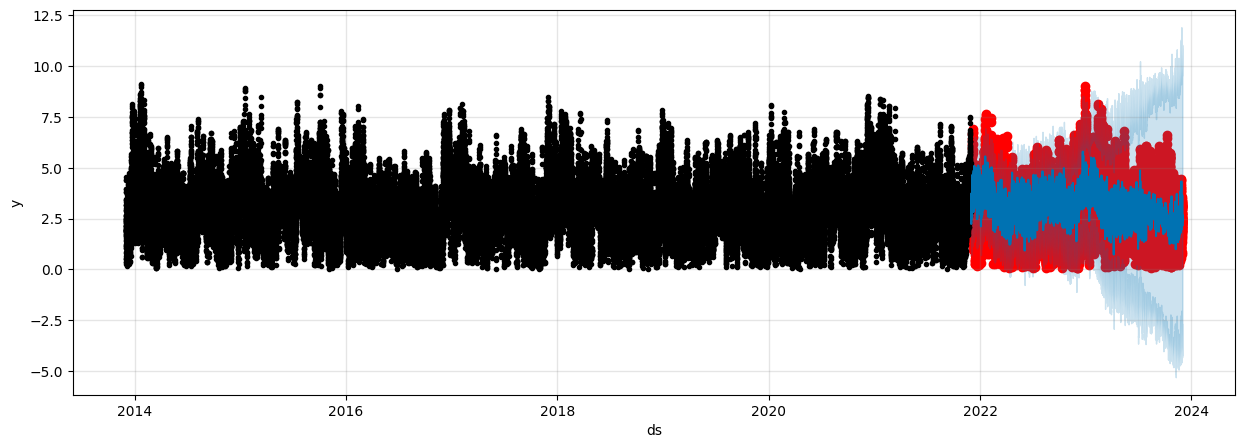

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_data.index, test_data['y'], color='r')
fig = model.plot(forecast, ax=ax)

c:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

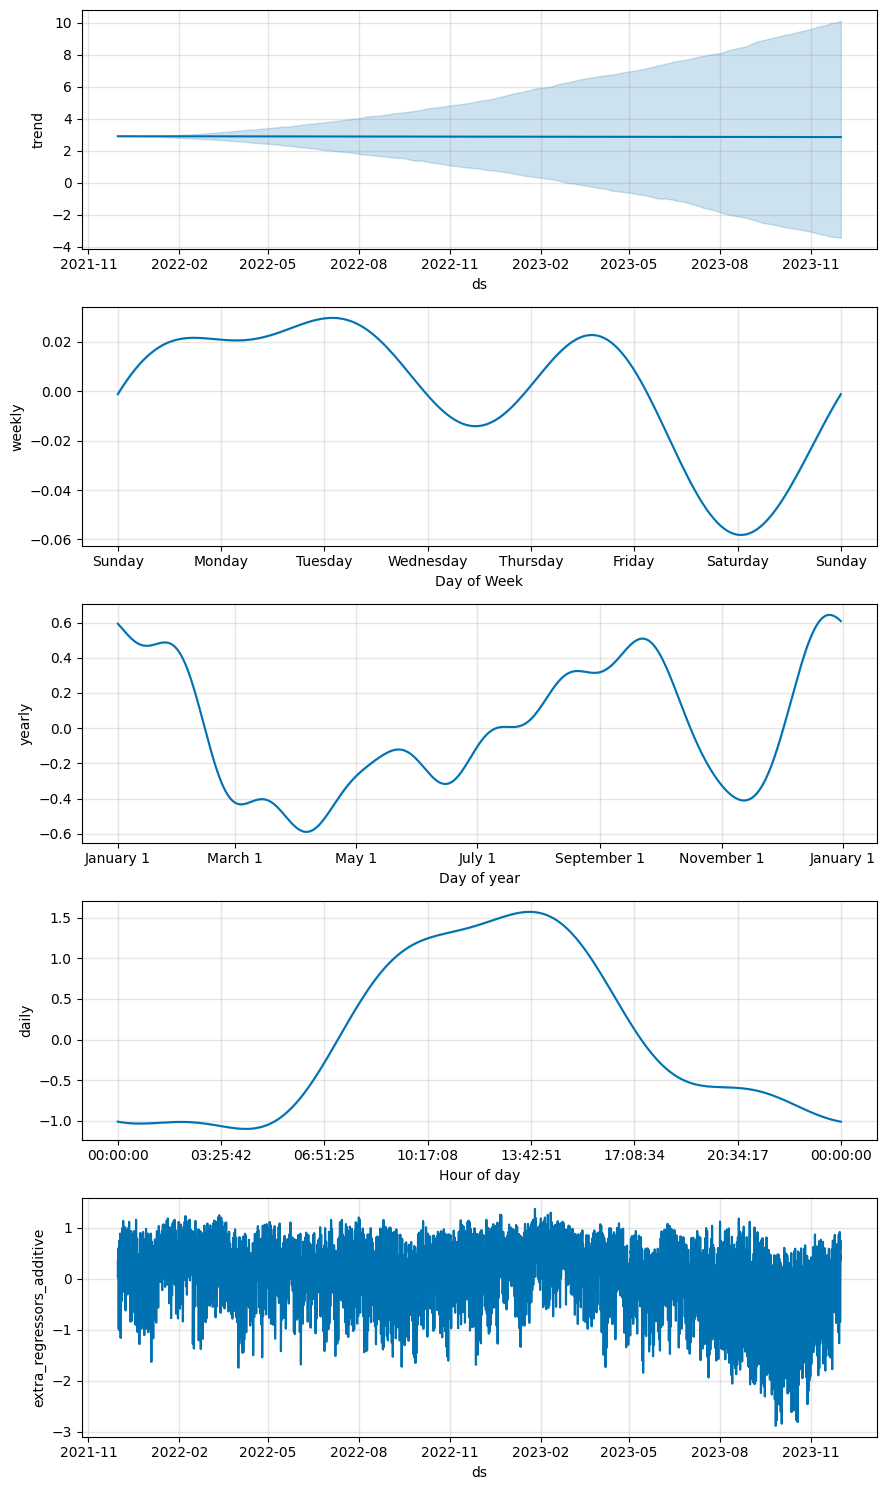

In [28]:
fig_comp = model.plot_components(forecast)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Menghitung mean absolute error (MAE) pada train set dan test set
train_mae = mean_absolute_error(train_data['y'], f_train['yhat'])
test_mae = mean_absolute_error(test_data['y'], forecast['yhat'])

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

from sklearn.metrics import accuracy_score
mean_value = df['y'].mean()
train_data['y_binary'] = (train_data['y'] > mean_value).astype(int)
test_data['y_binary'] = (test_data['y'] > mean_value).astype(int)
forecast['yhat_binary'] = (forecast['yhat'] > mean_value).astype(int)

# Mengambil prediksi biner untuk periode test set
forecast_test_binary = forecast['yhat_binary'].iloc[-len(test_data):].values
# Menghitung akurasi prediksi biner
accuracy = accuracy_score(test_data['y_binary'], forecast_test_binary)
print(f'Accuracy: {accuracy:.2f}')

f_train['yhat_binary'] = (f_train['yhat'] > mean_value).astype(int)
forecast['yhat_binary'] = (forecast['yhat'] > mean_value).astype(int)

# Mengambil prediksi biner untuk periode test set
forecast_test_binary = forecast['yhat_binary'].iloc[-len(test_data):].values

# Menghitung akurasi prediksi biner untuk data pelatihan
train_accuracy = accuracy_score(train_data['y_binary'], f_train['yhat_binary'])
print(f'Train Accuracy: {train_accuracy:.2f}')

# Menghitung akurasi prediksi biner untuk data pengujian
test_accuracy = accuracy_score(test_data['y_binary'], forecast_test_binary)
print(f'Test Accuracy: {test_accuracy:.2f}')

Train MAE: 0.869966707887492
Test MAE: 0.9289797605275163
Accuracy: 0.61
Train Accuracy: 0.67
Test Accuracy: 0.61


C:\Users\user\AppData\Local\Temp\ipykernel_12332\1514095118.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['y_binary'] = (train_data['y'] > mean_value).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_12332\1514095118.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['y_binary'] = (test_data['y'] > mean_value).astype(int)


In [30]:
f_train['yhat_binary'] = (f_train['yhat'] > mean_value).astype(int)
forecast['yhat_binary'] = (forecast['yhat'] > mean_value).astype(int)

# Mengambil prediksi biner untuk periode test set
forecast_test_binary = forecast['yhat_binary'].iloc[-len(test_data):].values

# Menghitung akurasi prediksi biner untuk data pelatihan
train_accuracy = accuracy_score(train_data['y_binary'], f_train['yhat_binary'])
print(f'Train Accuracy: {train_accuracy:.2f}')

# Menghitung akurasi prediksi biner untuk data pengujian
test_accuracy = accuracy_score(test_data['y_binary'], forecast_test_binary)
print(f'Test Accuracy: {test_accuracy:.2f}')

Train Accuracy: 0.67
Test Accuracy: 0.61


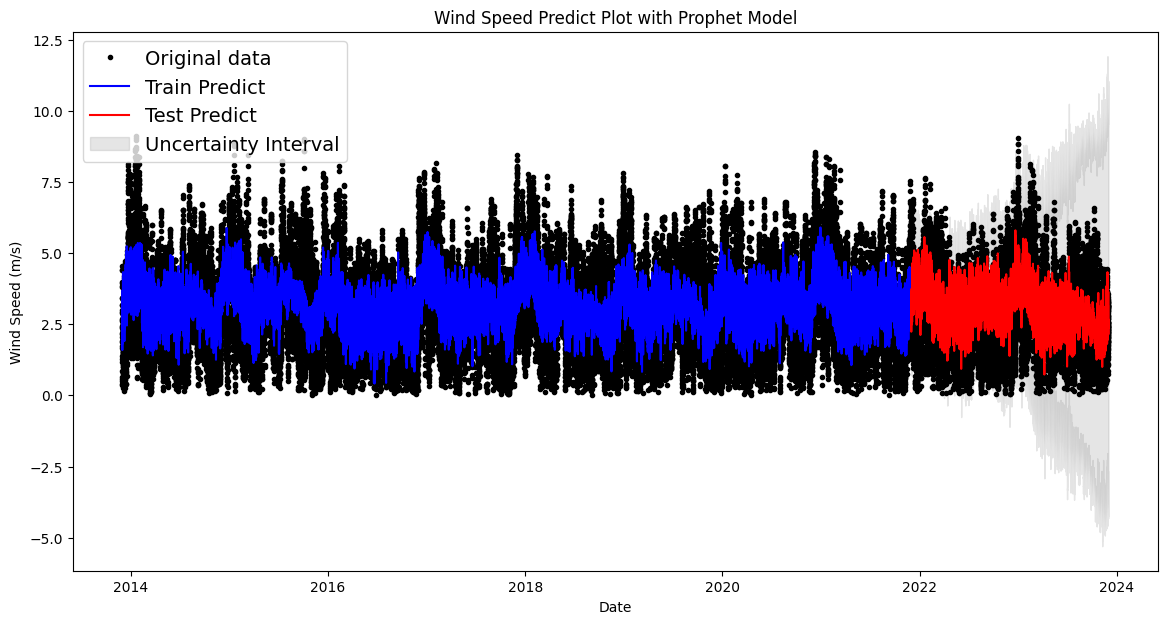

In [31]:
# Plot hasil prediksi
plt.figure(figsize=(14, 7))

# Plot data asli
plt.plot(df['ds'], df['y'], 'k.', label='Original data')

# Plot hasil prediksi train set
plt.plot(train_data['ds'], f_train['yhat'], 'b-', label='Train Predict')

# Plot hasil prediksi test set
plt.plot(test_data['ds'], forecast['yhat'], 'r-', label='Test Predict')

# Plot hasil prediksi test set
plt.fill_between(test_data['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')

# Menampilkan error pada grafik
# plt.text(train_data['ds'].iloc[-1], f_train['yhat'].iloc[-1], f'Train MAE: {train_mae:.2f}', fontsize=12, color='blue')
# plt.text(test_data['ds'].iloc[0], forecast['yhat'].iloc[train_size], f'Test MAE: {test_mae:.2f}', fontsize=12, color='red')
# plt.text(0.5, 0.01, f'Train_MAE: {train_mae:.2f}, Test_MSE: {test_mae:.2f}, train_acc: {train_accuracy:.2f}, test_acc: {test_accuracy:.2f}',transform=ax.transAxes,
#          fontsize=12, verticalalignment='bottom', horizontalalignment='center',
#          bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.legend(loc=2, prop={'size':14})
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Predict Plot with Prophet Model')
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

mae = mean_absolute_error(test_data['y'], forecast['yhat'])
mse = mean_squared_error(test_data['y'], forecast['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
r2 = r2_score(test_data['y'], forecast['yhat'])

In [33]:
print('mae :', mae)
print('mse :', mse)
print('rmse :', rmse)
print('mape :', mape)
print('r2score:', r2)

mae : 0.9289797605275163
mse : 1.3636904813110835
rmse : 1.1677715878163346
mape : 53.209085439432755
r2score: 0.15515944879149812


In [34]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_binary
0,2021-11-30 16:00:00,2.900492,2.391939,5.169827,2.900492,2.900492,0.819008,0.819008,0.819008,0.830742,...,0.014890,0.014890,-0.054609,-0.054609,-0.054609,0.0,0.0,0.0,3.719500,1
1,2021-11-30 17:00:00,2.900489,1.890620,4.641894,2.900489,2.900489,0.390986,0.390986,0.390986,0.211784,...,0.012887,0.012887,-0.053035,-0.053035,-0.053035,0.0,0.0,0.0,3.291475,1
2,2021-11-30 18:00:00,2.900486,1.436821,4.357317,2.900486,2.900486,0.030217,0.030217,0.030217,-0.285432,...,0.010823,0.010823,-0.051460,-0.051460,-0.051460,0.0,0.0,0.0,2.930703,0
3,2021-11-30 19:00:00,2.900483,1.245900,4.100182,2.900483,2.900483,-0.257637,-0.257637,-0.257637,-0.530408,...,0.008716,0.008716,-0.049882,-0.049882,-0.049882,0.0,0.0,0.0,2.642846,0
4,2021-11-30 20:00:00,2.900480,1.136603,3.924633,2.900480,2.900480,-0.358050,-0.358050,-0.358050,-0.583606,...,0.006587,0.006587,-0.048302,-0.048302,-0.048302,0.0,0.0,0.0,2.542430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17530,2023-12-01 02:00:00,2.847770,-4.493370,8.937622,-3.674799,9.117694,-0.453769,-0.453769,-0.453769,-1.011217,...,0.002500,0.002500,-0.057748,-0.057748,-0.057748,0.0,0.0,0.0,2.394002,0
17531,2023-12-01 03:00:00,2.847767,-4.137439,9.062394,-3.675292,9.118227,-0.353461,-0.353461,-0.353461,-1.037114,...,-0.000765,-0.000765,-0.056180,-0.056180,-0.056180,0.0,0.0,0.0,2.494306,0
17532,2023-12-01 04:00:00,2.847764,-4.368656,8.895637,-3.675786,9.118759,-0.419146,-0.419146,-0.419146,-1.092815,...,-0.004180,-0.004180,-0.054609,-0.054609,-0.054609,0.0,0.0,0.0,2.428618,0
17533,2023-12-01 05:00:00,2.847761,-4.390716,8.960737,-3.676279,9.119291,-0.382744,-0.382744,-0.382744,-1.042622,...,-0.007716,-0.007716,-0.053035,-0.053035,-0.053035,0.0,0.0,0.0,2.465017,0


In [35]:
import joblib

joblib.dump(fit_model, 'prophet_model_ws_new.pkl')

['prophet_model_ws_new.pkl']

In [36]:
model = joblib.load('prophet_model_ws_new.pkl')

C:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


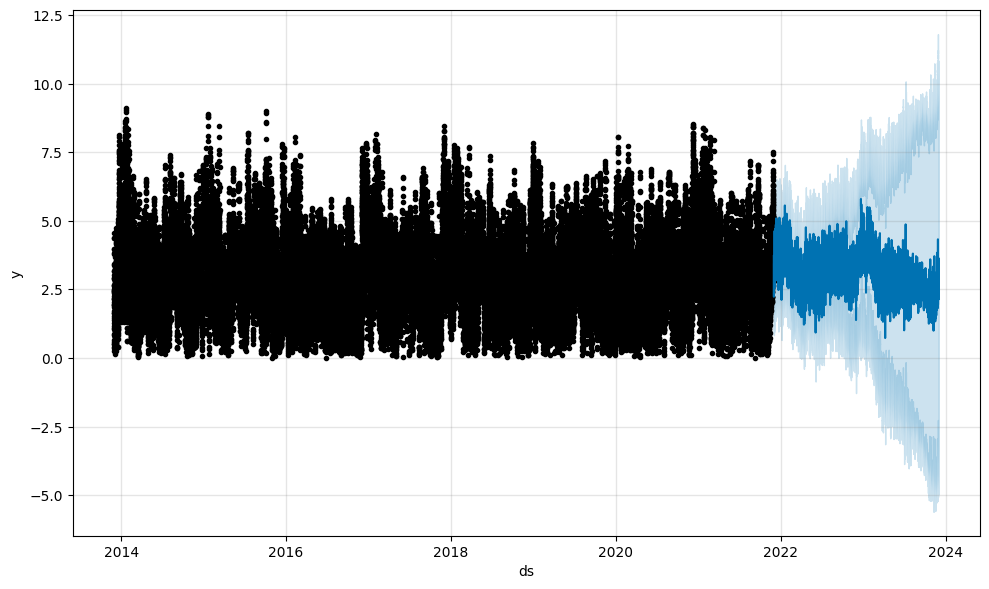

In [37]:
future_dates = pd.date_range(start='2024-06-01', end='2024-06-02', freq='h')
future = pd.DataFrame(future_dates, columns=['ds'])

# Add exogenous variables for future dates
# You can use any method to fill in these future values, for simplicity, I'm just repeating the last available value
future['rh2m'] = df['rh2m'].iloc[-1]
future['t2m'] = df['t2m'].iloc[-1]
future['ps'] = df['ps'].iloc[-1]

# Predict with exogenous variables
forecast = model.predict(test_data)

# Plot the forecast
fig = model.plot(forecast)

In [38]:
# Define new data point for prediction, including all regressors used in training
new_data_point = pd.DataFrame({
    'ds': ['2024-06-13 11:00:00'], 
    'y': [2], 
    'rh2m': [75],
    't2m': [34],
    'ps': [100]
})


# Make prediction using the loaded model
# forecast = model.predict(new_data_point)

# Display the prediction
print(forecast[['ds', 'yhat']])

                       ds      yhat
0     2021-11-30 16:00:00  3.719500
1     2021-11-30 17:00:00  3.291475
2     2021-11-30 18:00:00  2.930703
3     2021-11-30 19:00:00  2.642846
4     2021-11-30 20:00:00  2.542430
...                   ...       ...
17530 2023-12-01 02:00:00  2.394002
17531 2023-12-01 03:00:00  2.494306
17532 2023-12-01 04:00:00  2.428618
17533 2023-12-01 05:00:00  2.465017
17534 2023-12-01 06:00:00  2.651532

[17535 rows x 2 columns]


C:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\user\Documents\skripsi\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


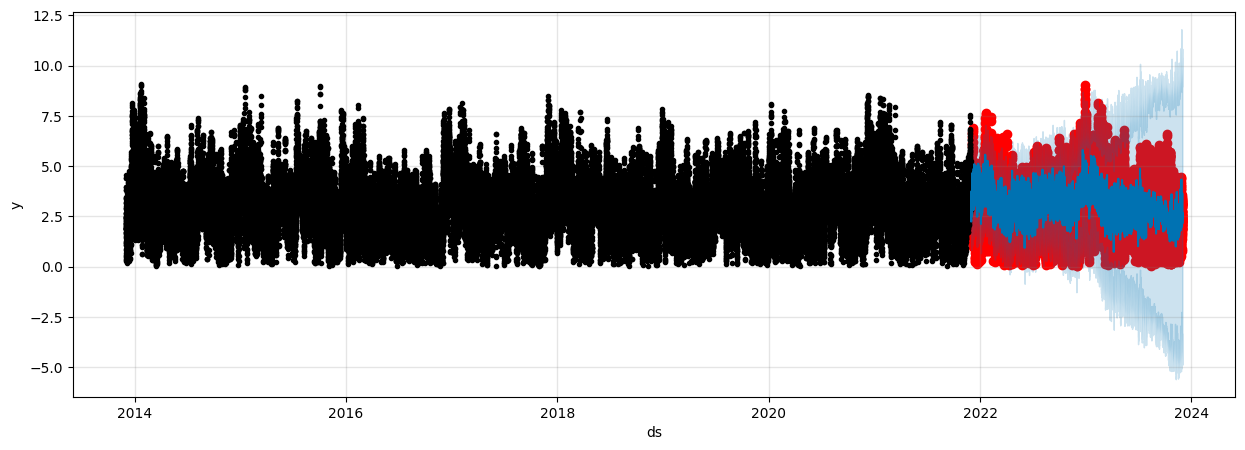

In [39]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_data.index, test_data['y'], color='r')
fig = model.plot(forecast, ax=ax)

# Hyperparamter TUNING

Exception raised for params {'growth': 'logistic', 'n_changepoints': 15, 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 2000, 'changepoint_range': 0.7960696668820462, 'seasonality_prior_scale': 15.307763020630075, 'changepoint_prior_scale': 0.004296270960961579, 'interval_width': 0.8393249542163514}: Capacities must be supplied for logistic growth in column "cap"
Iteration 1/20: Params: {'growth': 'logistic', 'n_changepoints': 15, 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 2000, 'changepoint_range': 0.7960696668820462, 'seasonality_prior_scale': 15.307763020630075, 'changepoint_prior_scale': 0.004296270960961579, 'interval_width': 0.8393249542163514} => MSE: inf


10:35:52 - cmdstanpy - INFO - Chain [1] start processing
10:37:14 - cmdstanpy - INFO - Chain [1] done processing


Iteration 2/20: Params: {'growth': 'linear', 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 500, 'changepoint_range': 0.6686386860681506, 'seasonality_prior_scale': 11.282746083595216, 'changepoint_prior_scale': 0.09666121859100586, 'interval_width': 0.22536132143699492} => MSE: 1.6065832926117445


10:37:23 - cmdstanpy - INFO - Chain [1] start processing
10:37:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration 3/20: Params: {'growth': 'linear', 'n_changepoints': 10, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 1500, 'changepoint_range': 0.9080414935207792, 'seasonality_prior_scale': 17.207361623081663, 'changepoint_prior_scale': 0.09487485143303913, 'interval_width': 0.3039075807020294} => MSE: 2.095878213994563


10:37:41 - cmdstanpy - INFO - Chain [1] start processing
10:37:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration 4/20: Params: {'growth': 'linear', 'n_changepoints': 10, 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'uncertainty_samples': 1000, 'changepoint_range': 0.8323882105848992, 'seasonality_prior_scale': 15.969860410305806, 'changepoint_prior_scale': 0.09436954317148193, 'interval_width': 0.22256461369156766} => MSE: 1.5694948006327194


10:37:55 - cmdstanpy - INFO - Chain [1] start processing
10:38:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration 5/20: Params: {'growth': 'linear', 'n_changepoints': 20, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 2000, 'changepoint_range': 0.561946123450143, 'seasonality_prior_scale': 11.266979258597313, 'changepoint_prior_scale': 0.09239677014655752, 'interval_width': 0.5513451954683872} => MSE: 1.5933344352272365
Exception raised for params {'growth': 'logistic', 'n_changepoints': 20, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'uncertainty_samples': 500, 'changepoint_range': 0.7821952928380427, 'seasonality_prior_scale': 16.97962947191549, 'changepoint_prior_scale': 0.08973392110897746, 'interval_width': 0.4710486528632536}: Capacities must be supplied for logistic growth in column "cap"
Iteration 6/20: Params: {'growth': 'logistic', 'n_changepoints': 20, 'yearly_seasonality': False, 'weekly_seasonality': Fals

10:38:49 - cmdstanpy - INFO - Chain [1] start processing
10:40:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration 7/20: Params: {'growth': 'linear', 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'uncertainty_samples': 1000, 'changepoint_range': 0.5077063681895161, 'seasonality_prior_scale': 17.218211052742504, 'changepoint_prior_scale': 0.06128912494620429, 'interval_width': 0.23114081739394765} => MSE: 1.5095115545559774


10:40:09 - cmdstanpy - INFO - Chain [1] start processing
10:40:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration 8/20: Params: {'growth': 'linear', 'n_changepoints': 0, 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'uncertainty_samples': 500, 'changepoint_range': 0.6539669373210935, 'seasonality_prior_scale': 9.739483461091343, 'changepoint_prior_scale': 0.043612100222416496, 'interval_width': 0.4339898263518082} => MSE: 1.526162920540443


10:40:13 - cmdstanpy - INFO - Chain [1] start processing
10:40:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration 9/20: Params: {'growth': 'linear', 'n_changepoints': 50, 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 2000, 'changepoint_range': 0.7484694421814987, 'seasonality_prior_scale': 17.57498115643264, 'changepoint_prior_scale': 0.03160532196678802, 'interval_width': 0.43174264884771096} => MSE: 1.6955242548096274


10:41:03 - cmdstanpy - INFO - Chain [1] start processing
10:41:18 - cmdstanpy - INFO - Chain [1] done processing


Iteration 10/20: Params: {'growth': 'linear', 'n_changepoints': 15, 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 2000, 'changepoint_range': 0.8169096491213046, 'seasonality_prior_scale': 7.22386921343093, 'changepoint_prior_scale': 0.0995834979334767, 'interval_width': 0.512398787577813} => MSE: 1.6273925066776282
Exception raised for params {'growth': 'logistic', 'n_changepoints': 30, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'uncertainty_samples': 1000, 'changepoint_range': 0.9714094075862965, 'seasonality_prior_scale': 19.575797609941873, 'changepoint_prior_scale': 0.06056604659620081, 'interval_width': 0.7662858492178757}: Capacities must be supplied for logistic growth in column "cap"
Iteration 11/20: Params: {'growth': 'logistic', 'n_changepoints': 30, 'yearly_seasonality': True, 'weekly_seasonality': False,

10:41:31 - cmdstanpy - INFO - Chain [1] start processing
10:42:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration 12/20: Params: {'growth': 'linear', 'n_changepoints': 45, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 1500, 'changepoint_range': 0.7027480441749027, 'seasonality_prior_scale': 17.124077447141644, 'changepoint_prior_scale': 0.06317470893464704, 'interval_width': 0.9165954746898726} => MSE: 1.7006250143958952


10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration 13/20: Params: {'growth': 'linear', 'n_changepoints': 50, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 1000, 'changepoint_range': 0.954290515844213, 'seasonality_prior_scale': 11.310277999290205, 'changepoint_prior_scale': 0.016856618861759497, 'interval_width': 0.8735672962475003} => MSE: 1.7355615299931297
Exception raised for params {'growth': 'logistic', 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'uncertainty_samples': 1500, 'changepoint_range': 0.864602042326212, 'seasonality_prior_scale': 14.351945622671419, 'changepoint_prior_scale': 0.09367063586916488, 'interval_width': 0.6202899528645291}: Capacities must be supplied for logistic growth in column "cap"
Iteration 14/20: Params: {'growth': 'logistic', 'n_changepoints': 35, 'yearly_seasonality': True, 'weekly_seasonality

10:43:43 - cmdstanpy - INFO - Chain [1] start processing
10:44:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration 17/20: Params: {'growth': 'linear', 'n_changepoints': 20, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'additive', 'uncertainty_samples': 1000, 'changepoint_range': 0.5142908537042279, 'seasonality_prior_scale': 5.893673446225835, 'changepoint_prior_scale': 0.09663574882351562, 'interval_width': 0.729895206125101} => MSE: 1.5119332483612526


10:44:36 - cmdstanpy - INFO - Chain [1] start processing
10:44:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration 18/20: Params: {'growth': 'linear', 'n_changepoints': 45, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'uncertainty_samples': 1000, 'changepoint_range': 0.5252456992607404, 'seasonality_prior_scale': 12.789615978493314, 'changepoint_prior_scale': 0.010024725274459845, 'interval_width': 0.9075267109597884} => MSE: 1.6240515174566652
Exception raised for params {'growth': 'logistic', 'n_changepoints': 50, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'uncertainty_samples': 2000, 'changepoint_range': 0.5094412588505404, 'seasonality_prior_scale': 8.519110949256502, 'changepoint_prior_scale': 0.08401743510901773, 'interval_width': 0.9261526648629372}: Capacities must be supplied for logistic growth in column "cap"
Iteration 19/20: Params: {'growth': 'logistic', 'n_changepoints': 50, 'yearly_seasonality': False, 'weekly_seasonality': Fals

10:45:00 - cmdstanpy - INFO - Chain [1] start processing
10:46:09 - cmdstanpy - INFO - Chain [1] done processing


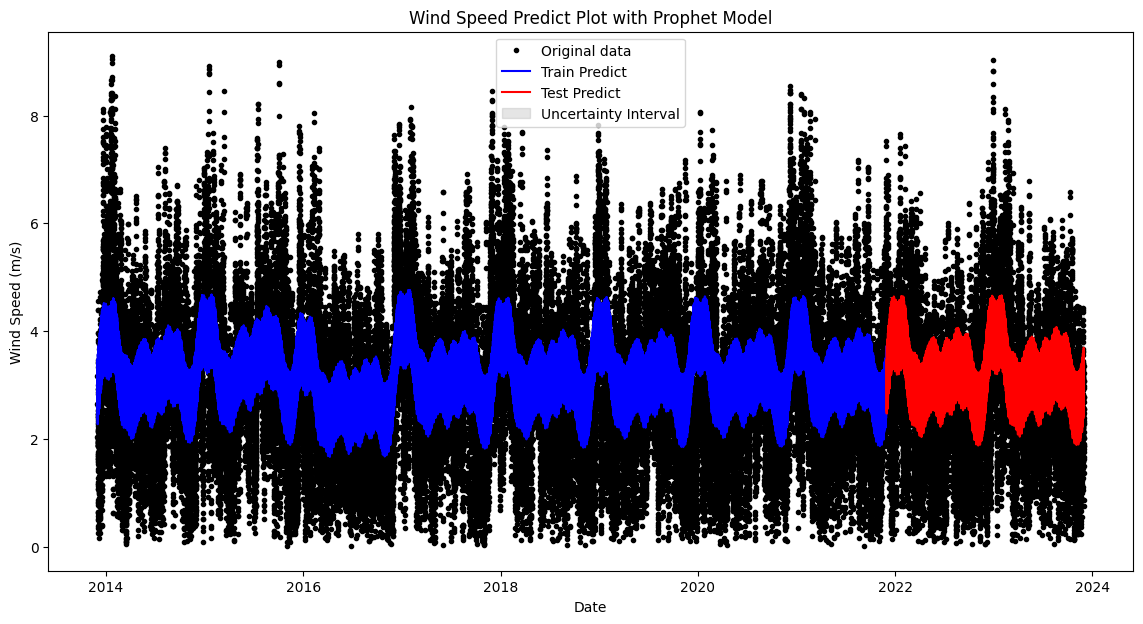

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform
import random
from itertools import product

def objective_function(args_list, train_data, test_data):
    params_evaluated = []
    results = []

    for idx, params in enumerate(args_list):
        try:
            model = Prophet(**params)
            model.fit(train_data)
            forecast = model.predict(test_data)
            mae = mean_absolute_error(test_data['y'], forecast['yhat'])
            mse = mean_squared_error(test_data['y'], forecast['yhat'])
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
            r2 = r2_score(test_data['y'], forecast['yhat'])

            params_evaluated.append(params)
            results.append(mse)  # Assuming you are optimizing for MSE, you can change this to any other metric
        except Exception as e:
            params_evaluated.append(params)
            results.append(float('inf'))  # Giving high loss for exceptions regions of space
            print(f"Exception raised for params {params}: {e}")

        print(f"Iteration {idx + 1}/{len(args_list)}: Params: {params} => MSE: {results[-1]}")

    return params_evaluated, results

param_space = dict(
    growth=['linear', 'logistic'],
    n_changepoints=range(0, 55, 5),
    yearly_seasonality=[True, False],
    weekly_seasonality=[True, False],
    daily_seasonality=[True, False],
    seasonality_mode=['additive', 'multiplicative'],
    uncertainty_samples=[500, 1000, 1500, 2000]
)

conf_Dict = dict()
conf_Dict['num_iteration'] = 20

# Create combinations of the discrete parameters
discrete_param_combinations = list(product(
    param_space['growth'],
    param_space['n_changepoints'],
    param_space['yearly_seasonality'],
    param_space['weekly_seasonality'],
    param_space['daily_seasonality'],
    param_space['seasonality_mode'],
    param_space['uncertainty_samples']
))

# Adjust for other parameters that are generated from uniform distributions
param_combinations = []
for params in discrete_param_combinations:
    params_dict = {
        'growth': params[0],
        'n_changepoints': params[1],
        'yearly_seasonality': params[2],
        'weekly_seasonality': params[3],
        'daily_seasonality': params[4],
        'seasonality_mode': params[5],
        'uncertainty_samples': params[6],
        'changepoint_range': uniform(0.5, 0.5).rvs(),
        'seasonality_prior_scale': uniform(5.0, 15.0).rvs(),
        'changepoint_prior_scale': uniform(0.0, 0.1).rvs(),
        'interval_width': uniform(0.2, 0.8).rvs()
    }
    param_combinations.append(params_dict)

# Select num_iteration parameter combinations randomly
selected_combinations = random.sample(param_combinations, conf_Dict['num_iteration'])

# Assuming train_data and test_data are defined elsewhere in your code
# Run the objective function for the selected parameter combinations
params_evaluated, results = objective_function(selected_combinations, train_data, test_data)

# Output the best parameters and result
best_idx = np.argmin(results)
best_params = params_evaluated[best_idx]
best_result = results[best_idx]

print(f"Best Parameters: {best_params}")
print(f"Best MSE: {best_result}")

# Fit the best model
best_model = Prophet(**best_params)
best_model.fit(train_data)
f_train = best_model.predict(train_data)
forecast = best_model.predict(test_data)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(df['ds'], df['y'], 'k.', label='Original data')

# Plot predictions on the training set
plt.plot(train_data['ds'], f_train['yhat'], 'b-', label='Train Predict')

# Plot predictions on the test set
plt.plot(test_data['ds'], forecast['yhat'], 'r-', label='Test Predict')

# Plot uncertainty intervals on the test set
plt.fill_between(test_data['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')

# Display the legend
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Predict Plot with Prophet Model')
plt.show()


In [41]:
# # Find the best parameters based on the results
# best_index = np.argmin(results)
# best_params = params_evaluated[best_index]
# best_result = results[best_index]

# print(f"Best Params: {best_params} => Best Result: {best_result}")

# # Retrain the model with the best parameters on the entire training dataset
# best_model = Prophet(**best_params)
# best_model.fit(train_data)

# # Make predictions on the test dataset
# forecast = best_model.predict(test_data)

# # Evaluate the model performance
# mae = mean_absolute_error(test_data['y'], forecast['yhat'])
# mse = mean_squared_error(test_data['y'], forecast['yhat'])
# rmse = np.sqrt(mse)
# mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
# r2 = r2_score(test_data['y'], forecast['yhat'])

# print(f"Model Performance on Test Data:")
# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"MAPE: {mape}%")
# print(f"R2 Score: {r2}")


In [42]:
# import numpy as np
# from prophet import Prophet
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from scipy.stats import uniform
# from scipy.optimize import fmin

# def objective_function(args_list):
#     global train_data, test_data

#     params_evaluated = []
#     results = []

#     for params in args_list:
#         try:
#             model = Prophet(**params)
#             model.fit(train_data)
#             forecast = model.predict(test_data)
#             mae = mean_absolute_error(test_data['y'], forecast['yhat'])
#             mse = mean_squared_error(test_data['y'], forecast['yhat'])
#             rmse = np.sqrt(mse)
#             mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
#             r2 = r2_score(test_data['y'], forecast['yhat'])

#             params_evaluated.append(params)
#             results.append(mse)  # Assuming you are optimizing for MSE, you can change this to any other metric
#         except:
#             params_evaluated.append(params)
#             results.append(25.0)  # Giving high loss for exceptions regions of space

#     # Printing the evaluated parameters and their results
#     for param, result in zip(params_evaluated, results):
#         print(f"Params: {param} => Result: {result}")

#     return params_evaluated, results

# param_space = dict(
#     growth=['linear', 'logistic', 'flat'],
#     n_changepoints=range(0, 55, 5),
#     changepoint_range=uniform(0.5, 0.5),
#     yearly_seasonality=[True, False],
#     weekly_seasonality=[True, False],
#     daily_seasonality=[True, False],
#     seasonality_mode=['additive', 'multiplicative'],
#     seasonality_prior_scale=uniform(5.0, 15.0),
#     changepoint_prior_scale=uniform(0.0, 0.1),
#     interval_width=uniform(0.2, 0.8),
#     uncertainty_samples=[500, 1000, 1500, 2000]
# )

# conf_Dict = dict()
# conf_Dict['initial_random'] = 10
# conf_Dict['num_iteration'] = 50

In [43]:
# from itertools import product

# discrete_param_combinations = list(product(
#     param_space['growth'],
#     param_space['n_changepoints'],
#     param_space['yearly_seasonality'],
#     param_space['weekly_seasonality'],
#     param_space['daily_seasonality'],
#     param_space['seasonality_mode'],
#     param_space['uncertainty_samples']
# ))

# param_combinations = []
# for params in discrete_param_combinations:
#     params_dict = {
#         'growth': params[0],
#         'n_changepoints': params[1],
#         'yearly_seasonality': params[2],
#         'weekly_seasonality': params[3],
#         'daily_seasonality': params[4],
#         'seasonality_mode': params[5],
#         'uncertainty_samples': params[6],
#         'changepoint_range': uniform(0.5, 0.5).rvs(),
#         'seasonality_prior_scale': uniform(5.0, 15.0).rvs(),
#         'changepoint_prior_scale': uniform(0.0, 0.1).rvs(),
#         'interval_width': uniform(0.2, 0.8).rvs()
#     }
#     param_combinations.append(params_dict)

# # Run the objective function
# params_evaluated, results = objective_function(param_combinations)

# # Find the best parameters based on the results
# best_index = np.argmin(results)
# best_params = params_evaluated[best_index]
# best_result = results[best_index]

# print(f"Best Params: {best_params} => Best Result: {best_result}")

In [44]:
# from itertools import product

# param_combinations = list(product(
#     param_space['growth'],
#     param_space['n_changepoints'],
#     param_space['yearly_seasonality'],
#     param_space['weekly_seasonality'],
#     param_space['daily_seasonality'],
#     param_space['seasonality_mode'],
#     param_space['uncertainty_samples']
# ))

# # Adjust for other parameters that are generated from uniform distributions
# for params in param_combinations:
#     params_dict = {
#         'growth': params[0],
#         'n_changepoints': params[1],
#         'yearly_seasonality': params[2],
#         'weekly_seasonality': params[3],
#         'daily_seasonality': params[4],
#         'seasonality_mode': params[5],
#         'uncertainty_samples': params[6],
#         'changepoint_range': uniform(0.5, 0.5).rvs(),
#         'seasonality_prior_scale': uniform(5.0, 15.0).rvs(),
#         'changepoint_prior_scale': uniform(0.0, 0.1).rvs(),
#         'interval_width': uniform(0.2, 0.8).rvs()
#     }
#     param_combinations.append(params_dict)

# # Run the objective function
# params_evaluated, results = objective_function(params_combinations)

# # Find the best parameters based on the results
# best_index = np.argmin(results)
# best_params = params_evaluated[best_index]
# best_result = results[best_index]

# print(f"Best Params: {best_params} => Best Result: {best_result}")

In [45]:
# def objective_function(args_list):
#     global train_data, test_data

#     params_evaluated = []
#     results = []

#     for params in args_list:
#         try:
#             model = Prophet(**params)
#             model.fit(train_data)
#             forecast = model.predict(test_data)
#             mae = mean_absolute_error(test_data['y'], forecast['yhat'])
#             mse = mean_squared_error(test_data['y'], forecast['yhat'])
#             rmse = np.sqrt(mse)
#             mape = np.mean(np.abs((np.array(test_data['y']) - np.array(forecast['yhat'])) / np.array(test_data['y']))) * 100
#             r2 = r2_score(test_data['y'], forecast['yhat'])

#             params_evaluated.append(params)
#             results.append(error)
#         except:
#             #print(f"Exception raised for {params}")
#             #pass
#             params_evaluated.append(params)
#             results.append(25.0)# Giving high loss for exceptions regions of spaces

#         #print(params_evaluated, mse)
#     return params_evaluated, results

In [46]:
# from scipy.stats import uniform


# param_space = dict(growth = ['linear', 'logistic', 'flat'],
#                    n_changepoints  = range(0, 55, 5),
#                    changepoint_range  = uniform(0.5, 0.5),
#                    yearly_seasonality = [True, False],
#                    weekly_seasonality = [True, False],
#                    daily_seasonality = [True, False],
#                    seasonality_mode = ['additive', 'multiplicative'],
#                    seasonality_prior_scale=uniform(5.0, 15.0),
#                    changepoint_prior_scale=uniform(0.0, 0.1),
#                    interval_width = uniform(0.2, 0.8),
#                    uncertainty_samples = [500, 1000, 1500, 2000]
#                    )

In [47]:
# conf_Dict = dict()
# conf_Dict['initial_random'] = 10
# conf_Dict['num_iteration'] = 50

In [48]:
# df.reset_index(inplace=True)

In [49]:
# def fit_prophet_model(params, data):
#     model = Prophet(
#         growth=params.get('growth', 'linear'),
#         n_changepoints=params.get('n_changepoints', 25),
#         changepoint_range=params.get('changepoint_range', 0.8),
#         yearly_seasonality=params.get('yearly_seasonality', True),
#         weekly_seasonality=params.get('weekly_seasonality', True),
#         daily_seasonality=params.get('daily_seasonality', True),  # For hourly data, daily seasonality is important
#         seasonality_mode=params.get('seasonality_mode', 'additive')
#     )
#     model.fit(data)
#     return model

# def make_predictions(model, periods, freq='H'):
#     future = model.make_future_dataframe(periods=periods, freq=freq)
#     forecast = model.predict(future)
#     return forecast

# def plot_results(model, forecast):
#     fig1 = model.plot(forecast)
#     plt.show()
#     fig2 = model.plot_components(forecast)
#     plt.show()
    
# def evaluate_model(model, data):
#     df_cv = cross_validation(model, initial='720 days', period='180 days', horizon='30 days')
#     df_performance = performance_metrics(df_cv)
#     return df_performance

# def grid_search(data):
#     param_grid = {
#         'growth': ['linear'], 
#         'changepoint_range': [0.8, 0.9],
#         'yearly_seasonality': [True, False],
#         'weekly_seasonality': [True, False],
#         'daily_seasonality': [True, False],
#         'seasonality_mode': ['additive', 'multiplicative']
#     }

#     best_params = None
#     best_score = float('inf')

#     for params in ParameterGrid(param_grid):
#         model = fit_prophet_model(params, data)
#         df_performance = evaluate_model(model, data)
#         score = df_performance['mape'].mean()  # Example scoring metric

#         if score < best_score:
#             best_score = score
#             best_params = params

#     return best_params, best_score



In [50]:
# if __name__ == "__main__":
#     # Load your dataset
    
#     # Split the dataset into training and testing sets


#     # Hyperparameter Tuning
#     best_params, best_score = grid_search(train_data.reset_index())
#     print(f'Best params: {best_params}')
#     print(f'Best score: {best_score}')

#     # Fit Model with Best Params
#     best_model = fit_prophet_model(best_params, train_data)

#     # Make Predictions
#     forecast = make_predictions(best_model, periods=len(test_data), freq='H')

#     # Plot Results
#     plot_results(best_model, forecast)
